0. INICIO

In [66]:
#IMPORTACIÓN DE LIBRERÍAS
import numpy as np
import pandas as pd
import scipy as scipy    #Libreria Python TestEstadisticos
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf  #sintáxis análoga a R
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import eli5  
from eli5.sklearn import PermutationImportance 
from lime import lime_tabular
import shap
shap.initjs() # para visualizar los gráficos de shap

In [2]:
#LECTURA DEL ARCHIVO CSV
datos = pd.read_csv('../pysparktfm/Stats_Global_18_22/part-00000-adc783a0-6f62-4ffe-bc1a-b167eb5b4ec3-c000.csv')

#PEQUEÑOS AJUSTES DEL ARCHIVO
datos['Año'] = datos['Año'].astype('object')
datos['Formation'] = datos['Formation'].astype('category')
datos['Pais'] = datos['Pais'].astype('category')
datos['Valor plantilla (mill. €)'] = datos['Valor plantilla (mill. €)'].astype('float64')
datos = datos.rename(columns={'sum(Min)': 'Min','sum(Sh)': 'Sh','sum(G)': 'G','sum(ShA)': 'ShA','sum(GA)': 'GA'})
#Equipos como el Chelsea tenían 1,02 mil millones. Multiplicamos por mil para pasarlo a millones
for index in range(datos.shape[0]):
    if datos.iloc[index, datos.columns.get_loc('Valor plantilla (mill. €)')] < 2:
        datos.iloc[index, datos.columns.get_loc('Valor plantilla (mill. €)')] = datos.iloc[index, datos.columns.get_loc('Valor plantilla (mill. €)')]*1000
#datos.info()
#datos.head(3)

In [3]:
#ARCHIVO MODIFICADO
#   ·Se eliminan las filas con menos de 120 mins y menos de 2 goles por ser poco representativas
#   ·Se inserta la columna 'NumDefensas': Numero de defensas
datos_mod = datos[((datos.Min < 120) & (datos.G >= 2)) | (datos.Min >= 120)]
datos_mod.insert(3,"NumDefensas","",True)
for a in range(0,len(datos_mod.index)):
    datos_mod.iloc[a,datos_mod.columns.get_loc('NumDefensas')] = datos_mod.iloc[a,datos_mod.columns.get_loc('Formation')][0]
datos_mod['NumDefensas'] = datos_mod['NumDefensas'].astype('category')
datos_mod = datos_mod.assign(GPart = datos_mod['G']/datos_mod['Min']*90)
datos_mod = datos_mod.assign(GAPart = datos_mod['GA']/datos_mod['Min']*90)

#datos_mod.info()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1. ANÁLISIS EXPLORATORIO DE LOS DATOS

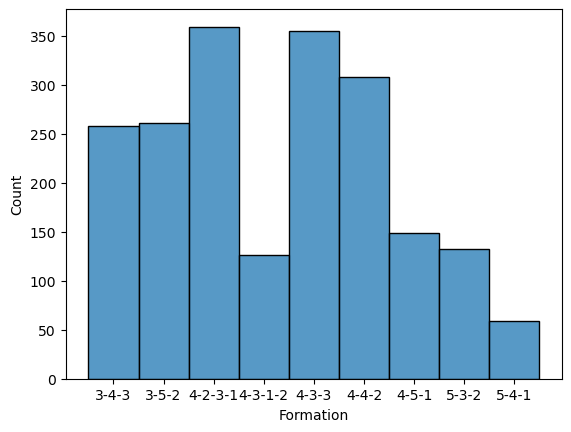

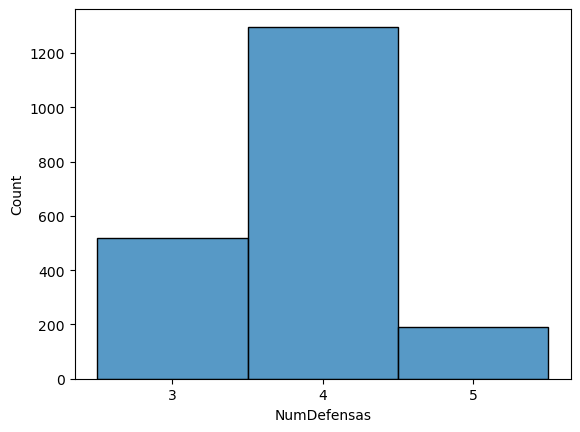

In [4]:
#NÚMERO DE VECES QUE SE HA UTILIZADO CADA FORAMCIÓN
sns.histplot(data=datos_mod, x="Formation")
plt.show()

#NÚMERO DE VECES QUE SE HAN UTILIZADO FORMACIONES SEGÚN NÚMERO DE DEFENSORES
sns.histplot(data=datos_mod, x="NumDefensas")
plt.show()

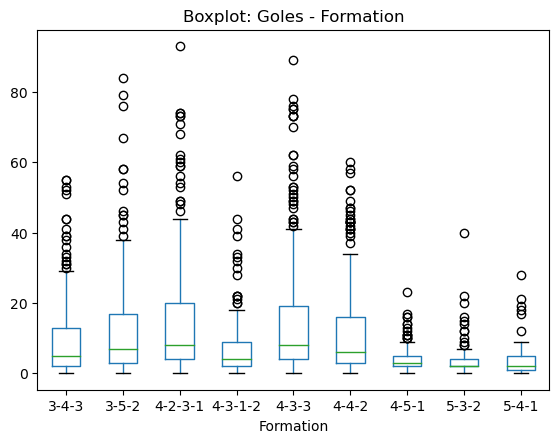

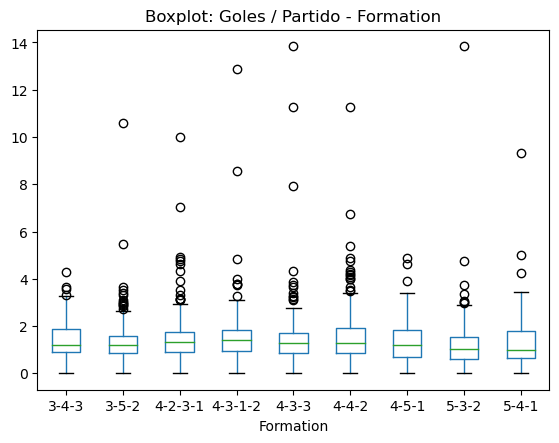

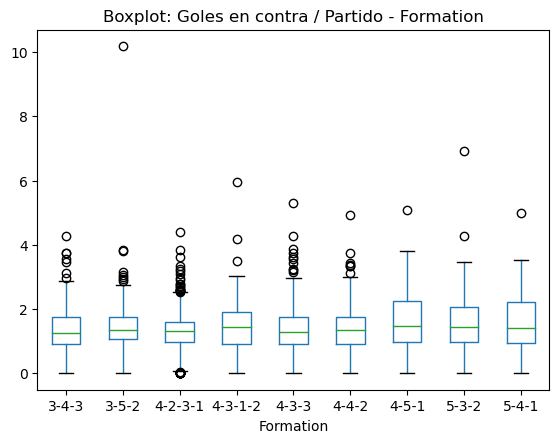

In [5]:
#RELACIONES ENTRE VARIABLES
boxplot=datos_mod.boxplot('G', by='Formation', grid=False) 
plt.title('Boxplot: Goles - Formation') ,plt.suptitle('') 
plt.show()
#Los goles a secas no son una buena medida ya que influyen mucho los minutos jugados con esa formación.

boxplot=datos_mod.boxplot('GPart', by='Formation', grid=False) 
plt.title('Boxplot: Goles / Partido - Formation') ,plt.suptitle('') 
plt.show()

boxplot=datos_mod.boxplot('GAPart', by='Formation', grid=False) 
plt.title('Boxplot: Goles en contra / Partido - Formation') ,plt.suptitle('') 
plt.show()

In [6]:
#Se necesita saber cuáles han sido los equipos más goleadores y con mayor tasa goleadora por partido para 
#eliminar los outliers. 
#datos_mod.sort_values('G',ascending=False).iloc[0:10]
#datos_mod.sort_values('GPart',ascending=False).iloc[0:10]
datos_mod.sort_values('GAPart',ascending=False).iloc[0:10]
#Calculamos los G/Part de los equipos más goleadores. Filtramos a partir del que mayor tasa tenga,
#en este caso: Bayern 2020 4-2-3-1: 93/2836*90 = 2.95 ...redondeando... 3.5

,Club,Año,Formation,NumDefensas,Min,Sh,G,ShA,GA,Edad,Valor plantilla (mill. €),Amarillas,Rojas,Posesión (%),Acierto Pase (%),Rating,Pais,GPart,GAPart
2435,Augsburg,2018,3-5-2,3,53,5,2,15,6,24.9,139.25,55,1,46.8,74.5,6.65,Alemania,3.396226,10.188679
2062,Mainz 05,2019,5-3-2,5,13,3,2,8,1,23.9,121.58,71,3,44.8,75.3,6.63,Alemania,13.846154,6.923077
1968,Genoa,2019,4-3-1-2,4,106,12,2,17,7,26.2,142.38,97,10,49.3,81.2,6.54,Italia,1.698113,5.943396
1417,Lens,2020,4-3-3,4,34,6,3,5,2,24.9,104.30,84,7,51.1,81.8,6.64,Francia,7.941176,5.294118
2351,Watford,2019,4-5-1,4,230,16,0,54,13,25.7,199.60,76,3,44.3,73.5,6.59,Inglaterra,0.000000,5.086957
1963,Freiburg,2019,5-4-1,5,36,3,2,15,2,25.8,122.65,41,2,17.9,78.4,6.70,Alemania,5.000000,5.000000
2676,Huddersfield,2018,4-4-2,4,128,9,1,37,7,25.3,137.45,55,4,47.1,75.8,6.47,Inglaterra,0.703125,4.921875
739,Greuther Fuerth,2021,4-2-3-1,4,143,12,1,23,7,24.6,36.95,61,0,43.0,74.8,6.38,Alemania,0.629371,4.405594
2155,Osasuna,2019,4-3-3,4,168,20,0,18,8,26.4,62.78,104,6,47.8,70.5,6.61,España,0.000000,4.285714
418,Strasbourg,2022,3-4-3,3,105,9,2,15,5,26.5,93.30,34,4,47.0,79.2,6.53,Francia,1.714286,4.285714


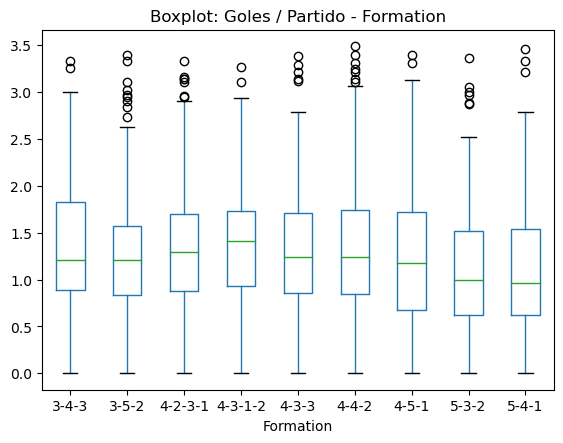

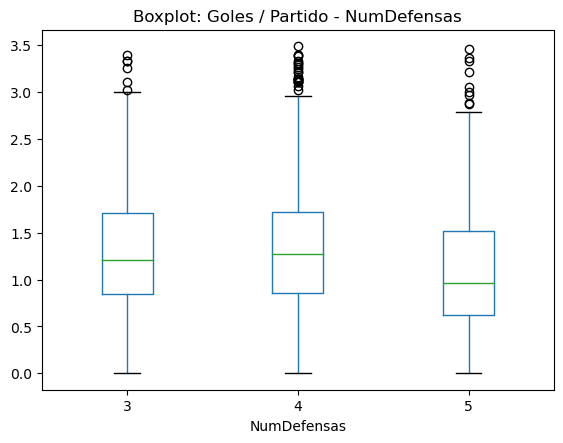

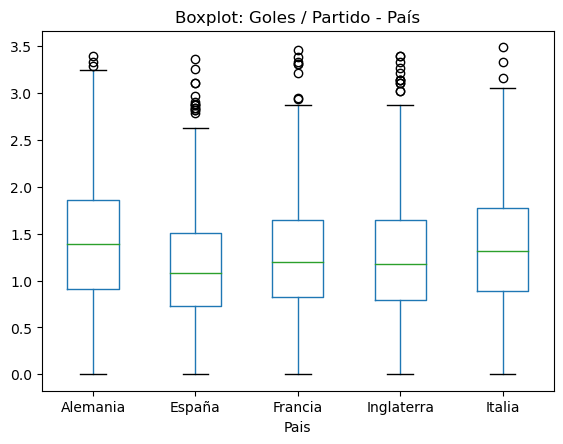

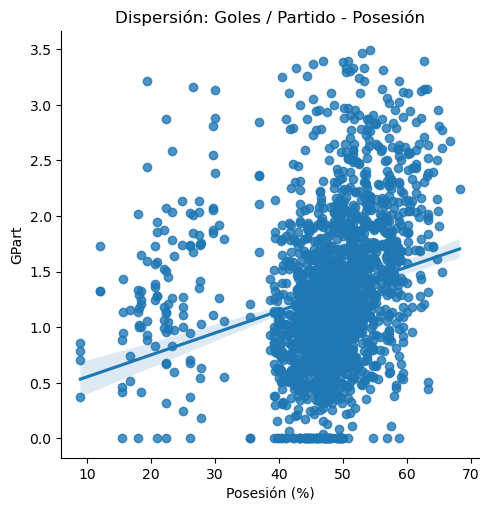

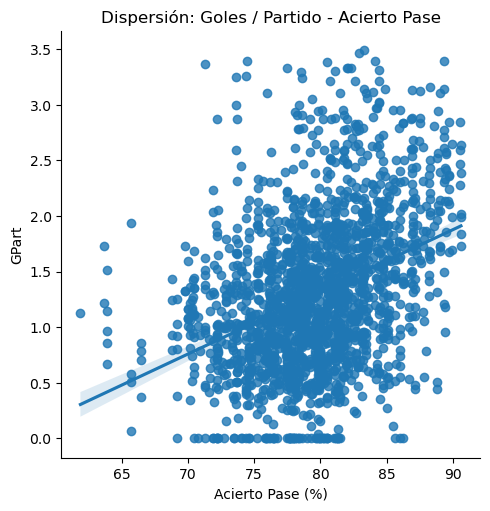

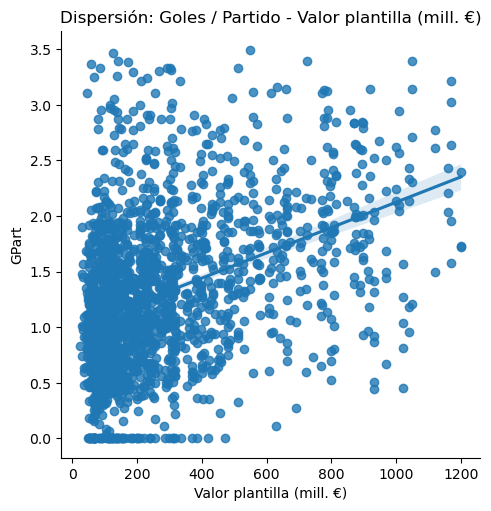

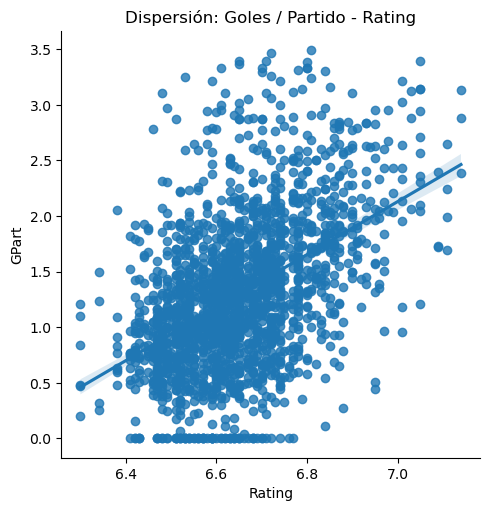

In [7]:
#Se eliminan las filas con más de 3.5 goles por partido
datos_mod = datos_mod[(datos_mod.GPart < 3.5)]

#Se realiza de nuevo el boxplot Goles / Partido - Formation
boxplot=datos_mod.boxplot('GPart', by='Formation', grid=False) 
plt.title('Boxplot: Goles / Partido - Formation') ,plt.suptitle('') 
plt.show()

#Otras relaciones de datos:
boxplot=datos_mod.boxplot('GPart', by='NumDefensas', grid=False) 
plt.title('Boxplot: Goles / Partido - NumDefensas') ,plt.suptitle('') 
plt.show()

boxplot=datos_mod.boxplot('GPart', by='Pais', grid=False) 
plt.title('Boxplot: Goles / Partido - País') ,plt.suptitle('') 
plt.show()

sns.lmplot(data=datos_mod, x="Posesión (%)", y="GPart", fit_reg=True)
plt.title('Dispersión: Goles / Partido - Posesión') ,plt.suptitle('') 
plt.show()

sns.lmplot(data=datos_mod, x="Acierto Pase (%)", y="GPart", fit_reg=True)
plt.title('Dispersión: Goles / Partido - Acierto Pase') ,plt.suptitle('') 
plt.show()

sns.lmplot(data=datos_mod, x="Valor plantilla (mill. €)", y="GPart", fit_reg=True)
plt.title('Dispersión: Goles / Partido - Valor plantilla (mill. €)') ,plt.suptitle('') 
plt.show()

sns.lmplot(data=datos_mod, x="Rating", y="GPart", fit_reg=True)
plt.title('Dispersión: Goles / Partido - Rating') ,plt.suptitle('') 
plt.show()

In [8]:
#Medidas básicas de goles y minutos
datos_1 = pd.DataFrame(data=datos_mod,columns=['Formation','NumDefensas','Min','G','GA','Pais','Posesión (%)'])
datos_1.describe()

,Min,G,GA,Posesión (%)
count,1954.000000,1954.000000,1954.000000,1954.000000
mean,838.639713,11.259980,11.047595,47.590020
std,1867.863111,13.783527,10.965910,8.490887
min,52.000000,0.000000,0.000000,8.900000
25%,205.000000,2.000000,3.000000,44.600000
50%,440.000000,6.000000,7.000000,48.300000
75%,1038.750000,15.000000,15.000000,51.900000
max,35946.000000,93.000000,78.000000,68.200000


The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


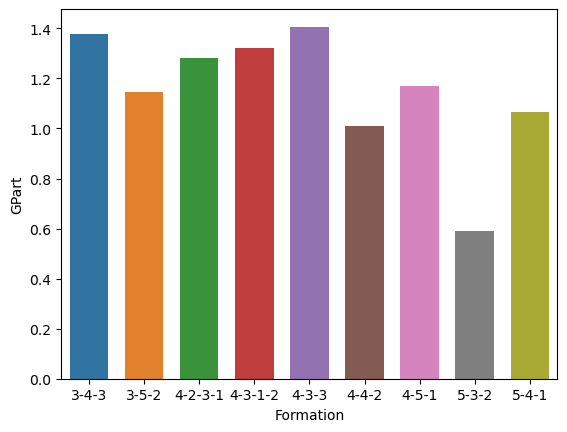

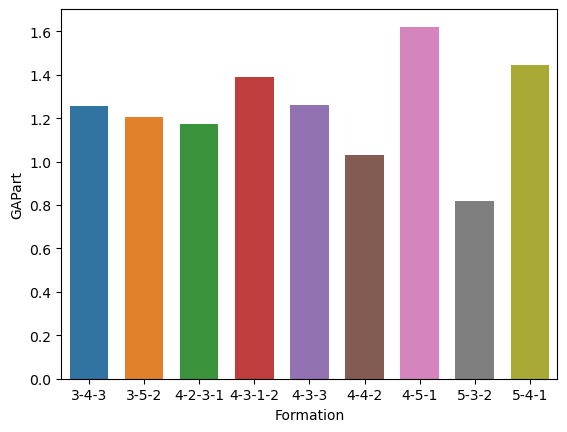

In [9]:
#Goles por partido según la formación
datos_2 = datos_1.groupby('Formation',as_index=False).sum()
datos_2 = datos_2.assign(GPart = datos_2['G']/datos_2['Min']*90)
datos_2 = datos_2.assign(GAPart = datos_2['GA']/datos_2['Min']*90)
#datos_2.reset_index()
#datos_2.describe()
#datos_2.head(9)
sns.barplot(data=datos_2, x='Formation', y='GPart', width=0.7)
plt.show()
sns.barplot(data=datos_2, x='Formation', y='GAPart', width=0.7)
plt.show()
#datos_2.info()

In [10]:
#Goles por partido según el número de defensas
datos_3 = datos_1.groupby('NumDefensas').sum()
datos_3 = datos_3.assign(GPart = datos_3['G']/datos_3['Min']*90)
datos_3.describe()
datos_3.head(3)

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,Min,G,GA,Posesión (%),GPart
NumDefensas,,,,,
3,418479,5745,5688,24514.6,1.235546
4,1125805,15527,14893,60136.3,1.241272
5,94418,730,1006,8340.0,0.695842


The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


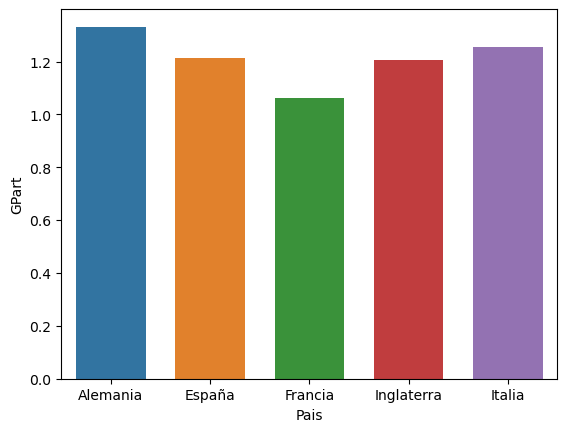

In [11]:
#Goles por partido según el país
datos_4 = datos_1.groupby('Pais',as_index=False).sum()
datos_4 = datos_4.assign(GPart = datos_4['G']/datos_4['Min']*90)
datos_4.describe()
datos_4.head(3)
sns.barplot(data=datos_4, x='Pais', y='GPart', width=0.7)
plt.show()

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


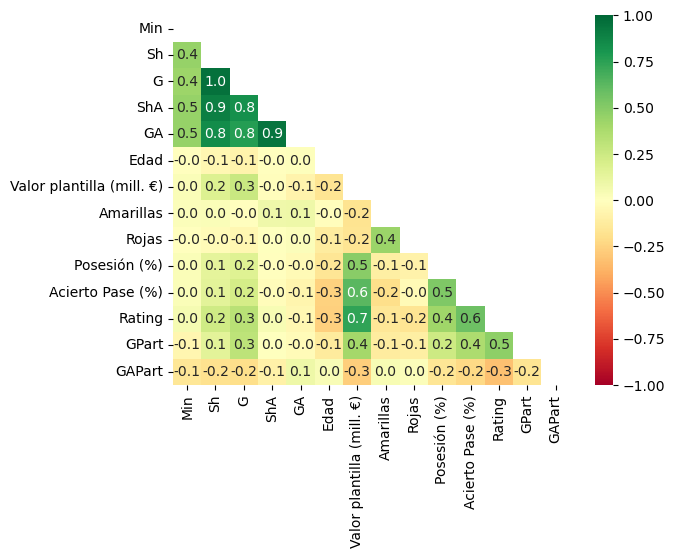

In [12]:
#MATRIZ DE CORRELACIÓN
correlacion = datos_mod.select_dtypes(exclude='object').corr()
mask = np.zeros(correlacion.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True
sns.heatmap(correlacion, annot = True, vmin = -1, vmax = 1, cmap = 'RdYlGn', mask=mask, fmt=".1f") 
plt.show()

2. RELACIÓN ENTRE FORMACIÓN Y GOLES

2.1 ANÁLISIS ANOVA

In [13]:
#MODELO ANOVA 1
anova1_datos = smf.ols('GPart ~ Formation', data=datos_mod).fit()
#anova_datos = smf.ols('G ~ 0 + Formation', data=datos).fit()  #para que salga sin intercepto
print(anova1_datos.summary())

#MODELO ANOVA 2
anova2_datos = smf.ols('GPart ~ NumDefensas', data=datos_mod).fit()
#anova_datos = smf.ols('G ~ 0 + Formation', data=datos).fit()  #para que salga sin intercepto
print(anova2_datos.summary())

#Como se puede observar por el R2, ni la Formación ni el Número de defensas explican correctamente la varible dependiente
#por lo que la regresión es mala.

                            OLS Regression Results                            
Dep. Variable:                  GPart   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     2.544
Date:                Wed, 22 Feb 2023   Prob (F-statistic):            0.00935
Time:                        11:19:51   Log-Likelihood:                -2031.1
No. Observations:                1954   AIC:                             4080.
Df Residuals:                    1945   BIC:                             4130.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.3297 

2.2 TEST DE LEVENE

In [14]:
#Se comprueba si las formaciones tienen la misma varianza
datos_mod['Formation'].unique()   #para conocer las diferentes formaciones
data1 = datos_mod.loc[datos_mod['Formation']=='3-4-3']
data2 = datos_mod.loc[datos_mod['Formation']=='3-5-2']
data3 = datos_mod.loc[datos_mod['Formation']=='4-2-3-1']
data4 = datos_mod.loc[datos_mod['Formation']=='4-3-1-2']
data5 = datos_mod.loc[datos_mod['Formation']=='4-3-3']
data6 = datos_mod.loc[datos_mod['Formation']=='4-4-2']
data7 = datos_mod.loc[datos_mod['Formation']=='4-5-1']
data8 = datos_mod.loc[datos_mod['Formation']=='5-3-2']
data9 = datos_mod.loc[datos_mod['Formation']=='5-4-1']

test1_levene, p1_value =scipy.stats.levene(data1['GPart'], data2['GPart'], data3['GPart'], data4['GPart'], data5['GPart'],
                                           data6['GPart'], data7['GPart'], data8['GPart'], data9['GPart'], center='median')
print(f'Valor: {round(test1_levene,4)}')
print(f'p-value: {round(p1_value,4)}')

#El p-value es algo mayor a 0.05. Además, si no se hubieran eliminado los outliers sería aún más bajo. Por tanto,
#se acepta la hipótesis nula, es decir, la varianza de goles/partido con respecto a la mediana según la formación
#son iguales.


#Se comprueba si los número de defensas tienen la misma varianza
data10 = datos_mod.loc[datos_mod['NumDefensas']=='3']
data11 = datos_mod.loc[datos_mod['NumDefensas']=='4']
data12 = datos_mod.loc[datos_mod['NumDefensas']=='5']

test2_levene, p2_value =scipy.stats.levene(data10['GPart'], data11['GPart'], data12['GPart'], center='median')
print(f'Valor: {round(test2_levene,4)}')
print(f'p-value: {round(p2_value,4)}')

#No se puede rechazar la hipótesis nula ya que ambos p-value son superiores a 0.05. Por tanto,
#se afirma que las varianzas son iguales

Valor: 1.9347
p-value: 0.0511
Valor: 1.7014
p-value: 0.1827


In [15]:
#Por tanto, se concluye que la formación por si sóla no explica el número de goles por partido, pero si puede
#decirse, como se vio anteriormente, que los equipos más goleadores tiene predilección por algunas formaciones.

3. PROCESO DE MODELIZACIÓN

In [16]:
#En primer lugar, se dividen los datos entre train-test y predicción.
#Se utilizarán los datos de 2020 y 2021 para el train-test y los de 2022 se intentará predecirlos.
#Se elimina la columna Sh por estar muy correlacionada con G
#datos_ml = datos.drop(["Sh"], axis=1) ##
datos_ml = datos
train = datos_ml[datos_ml.Año.isin([2021, 2020, 2019, 2018])]
print(train['Año'].unique())

[2021 2020 2019 2018]


In [17]:
#En segundo lugar, se dividen los datos de train-test
#TRAIN 75% - TEST 25%
x_train, x_test, y_train, y_test = train_test_split(train.drop(["G","Club","Año"], axis=1),
                                                    train["G"], 
                                                    test_size=0.3, 
                                                    random_state=123)
# cross_validation
cv=RepeatedKFold(n_splits=10, n_repeats=2, random_state=123)

eval_metric = 'neg_mean_squared_error'

In [18]:
# Escalado de los datos de entrada
scale = StandardScaler().fit(x_train.select_dtypes(exclude=['object','category']))

x_train_scale = scale.transform(x_train.select_dtypes(exclude=['object','category']))
x_test_scale = scale.transform(x_test.select_dtypes(exclude=['object','category']))

x_train_scale=pd.DataFrame(x_train_scale, columns=x_train.select_dtypes(exclude=['object','category']).columns)
x_test_scale=pd.DataFrame(x_test_scale, columns=x_train.select_dtypes(exclude=['object','category']).columns)

In [19]:
#Conversión de las variables cualitativas a variables dummy
x_train_dummy = pd.get_dummies(x_train.select_dtypes(include=['object','category']), drop_first=True)
x_test_dummy = pd.get_dummies(x_test.select_dtypes(include=['object','category']), drop_first=True)

In [20]:
#Unión de dataframes de variables escaladas y dummy (train y test)
x_train_escale_dummy = pd.concat([x_train_scale, x_train_dummy.reset_index(drop=True)], axis=1)
x_test_escale_dummy = pd.concat([x_test_scale, x_test_dummy.reset_index(drop=True)], axis=1)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print(f'train - {x_train_escale_dummy.shape}')    #No tienen el mismo nº columnas porque al hacer la division hay distintos equipos. Ver x_train_dummy y x_test_dummy
print(f'test - {x_test_escale_dummy.shape}')
x_train_escale_dummy.head()

train - (1792, 23)
test - (769, 23)


,Min,Sh,ShA,GA,Edad,Valor plantilla (mill. €),Amarillas,Rojas,Posesión (%),Acierto Pase (%),...,Formation_4-3-1-2,Formation_4-3-3,Formation_4-4-2,Formation_4-5-1,Formation_5-3-2,Formation_5-4-1,Pais_España,Pais_Francia,Pais_Inglaterra,Pais_Italia
0,-0.305882,-0.530994,-0.586243,-0.640584,-0.051586,-0.628270,0.971794,-1.170265,-2.614260,0.610685,...,0,0,0,0,0,0,0,0,0,1
1,-0.268702,-0.595370,-0.514691,-0.546967,1.335542,-0.896779,-0.297367,-0.726055,0.111598,0.039688,...,0,0,0,0,1,0,1,0,0,0
2,-0.014081,-0.172328,0.200829,0.108349,1.038300,-0.628893,1.026975,0.162365,-0.231997,-0.383273,...,0,1,0,0,0,0,0,0,0,1
3,-0.212934,-0.347063,-0.432917,-0.453351,-0.249747,3.159535,-1.511348,-0.726055,1.497434,2.069900,...,0,0,0,1,0,0,0,0,1,0
4,-0.331231,-0.586173,-0.688460,-0.734200,-0.844231,-0.617671,-0.793996,1.494994,0.432288,0.314613,...,1,0,0,0,0,0,0,1,0,0


3.1 ARBOL DE REGRESION

In [45]:
cart=DecisionTreeRegressor(criterion='mse', random_state=123) #modelo base
grid=[{'max_depth': list(np.arange(5, 11, 1))}]

#definición del modelo con hiperparámetros
gs_cart=GridSearchCV(estimator=cart, param_grid=grid, scoring=eval_metric, cv=cv, n_jobs=-1, return_train_score=False)

#entrenamiento del modelo con hiperparámetros
gs_cart=gs_cart.fit(x_train_escale_dummy, y_train)

In [46]:
# Estudio entrenamiento del modelo con hiperparámetros -> validación cruzada
cv_results=pd.DataFrame.from_dict(gs_cart.cv_results_)  #data.frame con la información relativa al entrenamiento del modelo 

cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,mean_test_score,std_test_score,rank_test_score
0,0.018858,0.011705,0.000781,0.003405,5,{'max_depth': 5},-17.445544,-9.666592,-16.006369,-16.734825,...,-19.757316,-16.815917,-13.176676,-12.185065,-17.548041,-15.495718,-28.673815,-16.557095,4.754086,1
1,0.014062,0.012001,0.001562,0.004687,6,{'max_depth': 6},-16.049183,-10.225071,-16.023839,-19.324972,...,-26.361197,-16.671467,-12.184016,-13.687496,-11.128283,-17.719924,-27.171752,-17.174898,5.197579,2
2,0.017186,0.012001,0.005468,0.011348,7,{'max_depth': 7},-14.972420,-8.810332,-17.501764,-18.057086,...,-24.040133,-15.803494,-12.964912,-10.835570,-19.323791,-18.446752,-26.040363,-18.073204,5.774362,3
3,0.018392,0.006926,0.000981,0.003412,8,{'max_depth': 8},-15.748029,-7.757521,-18.090058,-19.506718,...,-27.302496,-15.248307,-13.200839,-12.636341,-14.737760,-23.459776,-24.449694,-18.864953,5.252824,4
4,0.020311,0.010004,0.002344,0.005579,9,{'max_depth': 9},-15.376922,-8.715692,-17.843638,-21.163260,...,-24.454246,-15.101768,-13.166316,-11.764342,-19.262218,-20.031962,-25.422061,-19.214343,5.041642,5


In [47]:
cart_model=gs_cart.best_estimator_ #modelo final

In [48]:
y_train_pred_cart = cart_model.predict(x_train_escale_dummy)
y_test_pred_cart = cart_model.predict(x_test_escale_dummy)

In [49]:
print('R2')
print('----')
print(f'Train: {np.round(r2_score(y_train, y_train_pred_cart),4)}')
print(f'Test: {np.round(r2_score(y_test, y_test_pred_cart),4)}')
print('MSE')
print('----')
print(f'Train: {np.round(mean_absolute_error(y_train, y_train_pred_cart),4)}')
print(f'Test: {np.round(mean_absolute_error(y_test, y_test_pred_cart),4)}')

R2
----
Train: 0.9577
Test: 0.9044
MSE
----
Train: 1.7027
Test: 2.0969


3.2 RANDOM FOREST

In [50]:
rf=RandomForestRegressor(criterion='mse', min_samples_split=5, random_state=123) #modelo base
grid=[{'n_estimators':[6, 8, 10, 12], 'max_depth': [2, 4]}]

#definición del modelo con hiperparámetros
gs_rf=GridSearchCV(estimator=rf, param_grid=grid, scoring=eval_metric, cv=cv, n_jobs=-1, return_train_score=False)

#entrenamiento del modelo con hiperparámetros
gs_rf=gs_rf.fit(x_train_escale_dummy, y_train)

In [51]:
rf_model=gs_rf.best_estimator_ #modelo final

In [52]:
y_train_pred_rf = rf_model.predict(x_train_escale_dummy)
y_test_pred_rf = rf_model.predict(x_test_escale_dummy)

In [53]:
print('R2')
print('----')
print(f'Train: {np.round(r2_score(y_train, y_train_pred_rf),4)}')
print(f'Test: {np.round(r2_score(y_test, y_test_pred_rf),4)}')
print('MSE')
print('----')
print(f'Train: {np.round(mean_absolute_error(y_train, y_train_pred_rf),4)}')
print(f'Test: {np.round(mean_absolute_error(y_test, y_test_pred_rf),4)}')

R2
----
Train: 0.9529
Test: 0.9228
MSE
----
Train: 1.7847
Test: 1.9292


3.3 GRADIENT BOOSTING

In [54]:
gbm = GradientBoostingRegressor(random_state=123, criterion='friedman_mse', min_samples_split=2)

grid=[{'n_estimators': list(np.arange(10, 25, 3)), 
        'max_depth':[4, 6],
        'learning_rate': [0.1, 0.2, 0.7]} ]  #hiperparámetros

#definición del modelo con hiperparámetros
gs_gbm=GridSearchCV(estimator=gbm, param_grid=grid, scoring=eval_metric, cv=cv, n_jobs=-1, return_train_score=False)

#entrenamiento del modelo con hiperparámetros
gs_gbm=gs_gbm.fit(x_train_escale_dummy, y_train)

In [55]:
gbm_model=gs_gbm.best_estimator_ #modelo final

In [56]:
y_train_pred_gbm = gbm_model.predict(x_train_escale_dummy)
y_test_pred_gbm = gbm_model.predict(x_test_escale_dummy)

In [57]:
print('R2')
print('----')
print(f'Train {np.round(r2_score(y_train, y_train_pred_gbm),4)}')
print(f'Test {np.round(r2_score(y_test, y_test_pred_gbm),4)}')
print('MSE')
print('----')
print(f'Train {np.round(mean_absolute_error(y_train, y_train_pred_gbm),4)}')
print(f'Test {np.round(mean_absolute_error(y_test, y_test_pred_gbm),4)}')

R2
----
Train 0.9777
Test 0.9263
MSE
----
Train 1.3708
Test 1.9072


3.4 LIGHTGBM

In [58]:
lgbm = LGBMRegressor(boosting_type='gbdt', objective='regression', random_state=123)

grid=[{'n_estimators': list(np.arange(10, 25, 3)), 
        'max_depth':[4, 6],
        'learning_rate': [0.1, 0.2, 0.7]} ]  #hiperparámetros

#definición del modelo con hiperparámetros
gs_lgbm=GridSearchCV(estimator=lgbm, param_grid=grid, scoring=eval_metric, cv=cv, n_jobs=-1, return_train_score=False)

#entrenamiento del modelo con hiperparámetros
gs_lgbm=gs_lgbm.fit(x_train_escale_dummy, y_train)

In [59]:
lgbm_model=gs_lgbm.best_estimator_ #modelo final

In [60]:
y_train_pred_lgbm = lgbm_model.predict(x_train_escale_dummy)
y_test_pred_lgbm = lgbm_model.predict(x_test_escale_dummy)

In [61]:
print('R2')
print('----')
print(f'Train {np.round(r2_score(y_train, y_train_pred_lgbm),4)}')
print(f'Test {np.round(r2_score(y_test, y_test_pred_lgbm), 4)}')
print('MSE')
print('----')
print(f'Train {np.round(mean_absolute_error(y_train, y_train_pred_lgbm),4)}')
print(f'Test {np.round(mean_absolute_error(y_test, y_test_pred_lgbm), 4)}')

R2
----
Train 0.9731
Test 0.9263
MSE
----
Train 1.3593
Test 1.9064


4. EXPLICABILIDAD DEL MODELO

Escogemos el modelo Gradient Boosting ya que tiene el mayor R2 y el menor MSE

4.1 LIBRERÍA ELI

In [38]:
eli5.show_weights(gbm_model, feature_names=list(x_test_escale_dummy.columns), show=['feature_importances'])

Weight,Feature
0.9239 ± 0.8578,Sh
0.0345 ± 0.5430,Min
0.0128 ± 0.1207,Rating
0.0063 ± 0.0795,Acierto Pase (%)
0.0053 ± 0.0730,Posesión (%)
0.0050 ± 0.3073,ShA
0.0044 ± 0.1061,Valor plantilla (mill. €)
0.0022 ± 0.1278,GA
0.0021 ± 0.1240,Edad
0.0020 ± 0.0779,Amarillas


4.2 LIBRERÍA SHAP

In [39]:
# explicar modelos de árboles de decisión
explainer = shap.TreeExplainer(gbm_model)
shap_values = explainer.shap_values(x_test_escale_dummy)
#shap_values = explainer.shap_values(x_predict_escale_dummy)

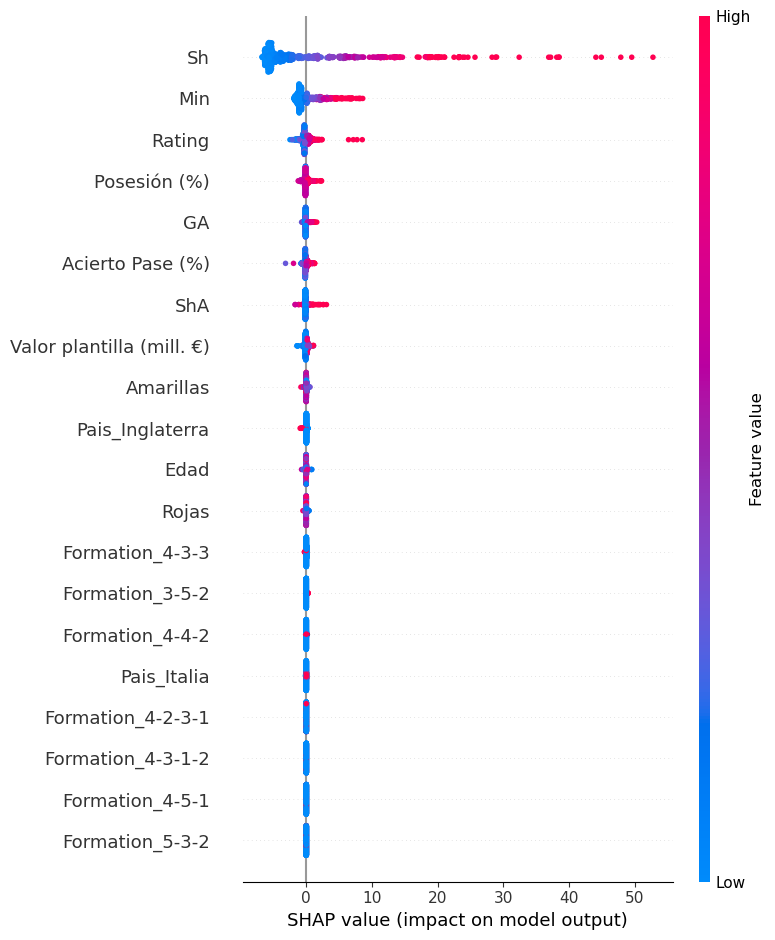

In [40]:
# impacto de los niveles de las variables en la salida del modelo
shap.summary_plot(shap_values, x_test_escale_dummy) 
#shap.summary_plot(shap_values, x_predict_escale_dummy) 

In [41]:
shap.force_plot(explainer.expected_value, shap_values, x_test_escale_dummy)
#shap.force_plot(explainer.expected_value, shap_values, x_predict_escale_dummy)

5. PREDICCIÓN DE GOLES

In [42]:
#Se predecirá los goles de los equipos de la temporada 2022
prediccion = datos_ml[datos_ml['Año'] == 2022]
print(prediccion['Año'].unique())
x_predict = prediccion.drop(["G","Club","Año"], axis=1) ##
y_predict = prediccion["G"] ##

# Escalado de los datos de entrada
scale = StandardScaler().fit(x_predict.select_dtypes(exclude=['object','category']))
x_predict_scale = scale.transform(x_predict.select_dtypes(exclude=['object','category']))
x_predict_scale=pd.DataFrame(x_predict_scale, columns=x_predict.select_dtypes(exclude=['object','category']).columns)

#Conversión de las variables cualitativas a variables dummy
x_predict_dummy = pd.get_dummies(x_predict.select_dtypes(include=['object','category']), drop_first=True)

#Unión de dataframes de variables escaladas y dummy (train y test)
x_predict_escale_dummy = pd.concat([x_predict_scale, x_predict_dummy.reset_index(drop=True)], axis=1)
y_predict = y_predict.reset_index(drop=True)
print(f'train - {x_train_escale_dummy.shape}')    
print(f'predict - {x_predict_escale_dummy.shape}')

[2022]
train - (1792, 23)
predict - (487, 23)


In [64]:
#Utilizando el gbm_model se obtiene los goles esperados
y_predict_pred_gbm = gbm_model.predict(x_predict_escale_dummy)

In [65]:
#Tabla con los goles marcados y esperados (simplificado solo con algunas columnas)
datos_prediccion = pd.DataFrame(data=prediccion,columns=['Año','Club','Formation','Min','G','Sh','Posesión (%)','Acierto Pase (%)','Rating'])
datos_prediccion.insert(5,"GPred",y_predict_pred_gbm,True)
datos_prediccion.head(15)

,Año,Club,Formation,Min,G,GPred,Sh,Posesión (%),Acierto Pase (%),Rating
0,2022,AC Milan,4-2-3-1,1489,31,48.117605,248,54.8,81.2,6.66
1,2022,AC Milan,4-3-3,103,2,2.502026,21,54.8,81.2,6.66
2,2022,AC Milan,5-3-2,81,1,0.880328,10,54.8,81.2,6.66
3,2022,AC Milan,3-5-2,60,0,1.168769,13,54.8,81.2,6.66
4,2022,AC Milan,4-4-2,37,1,0.512567,6,54.8,81.2,6.66
5,2022,AC Milan,3-4-3,35,0,0.512567,3,54.8,81.2,6.66
6,2022,AC Milan,5-4-1,10,0,0.512567,2,54.8,81.2,6.66
7,2022,Ajaccio,4-4-2,1629,15,33.110301,181,44.7,75.7,6.38
8,2022,Ajaccio,4-3-3,86,0,0.337347,3,44.7,75.7,6.38
9,2022,Ajaccio,5-4-1,48,1,0.337347,2,44.7,75.7,6.38
